In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from efgp1d import efgp1d, efgp1d_NUFFT, efgp1d_gradient_batched, compute_convolution_vector_vectorized
from efgp_1d_dense import efgp1d_dense
from typing import Dict, Optional, Callable, Tuple
from cg import ConjugateGradients, BatchConjugateGradients
from efgp1d import _cmplx
from typing import Optional, Tuple, Dict
import pytorch_finufft.functional as pff

import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# d-dimensional GP sampler 

In [46]:


# --- Parameters ---
n = 500  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.3
true_variance = 2
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 10
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# Squared Exponential Kernel Function for d-dimensional inputs
def squared_exponential_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """
    Squared Exponential kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles multi-dimensional (n, d) inputs.
    """
    # Compute pairwise squared Euclidean distances
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)                # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)                # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the Squared Exponential kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a d-dimensional Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n, d)
        Input points in d-dimensional space.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x)  # Shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance)  # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    try:
        L = torch.linalg.cholesky(K_noisy)  # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2

    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device)  # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    samples = mean.unsqueeze(1) + L @ Z  # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    mean_func_torch,
    squared_exponential_kernel,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=500 points in 2 dimensions...
Generated sample of size 500.
Time taken: 0.0018 seconds


In [47]:
sigmasq = torch.tensor([0.1])

Plotting the generated Gaussian Process data...


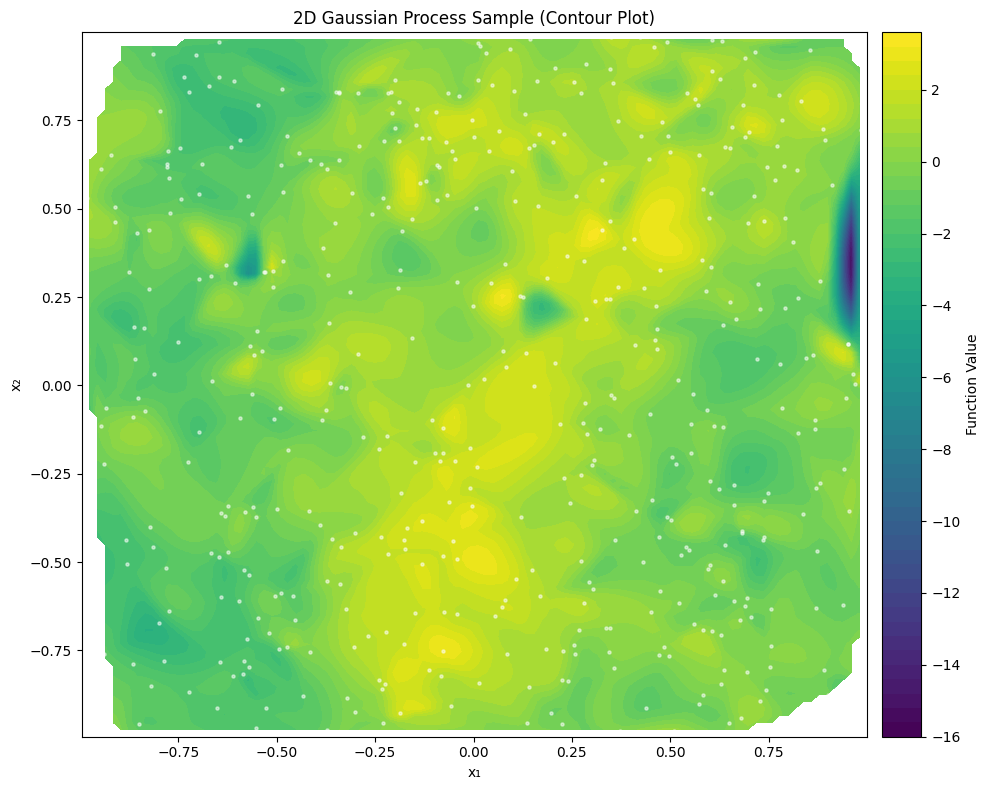

In [48]:
# --- Plot the Generated Data ---
print("Plotting the generated Gaussian Process data...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Determine the dimensionality of the data
d = x.shape[1]

if d == 1:
    # 1D plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x.cpu().numpy(), y.cpu().numpy(), alpha=0.7, s=10)
    plt.title('1D Gaussian Process Sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

elif d == 2:
    # 2D contour plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 0.05]})
    
    # Extract coordinates
    x1, x2 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create a regular grid for interpolation
    grid_size = 100
    x1_grid = np.linspace(x1.min(), x1.max(), grid_size)
    x2_grid = np.linspace(x2.min(), x2.max(), grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Interpolate the scattered data onto the regular grid
    Y_grid = griddata((x1, x2), y_values, (X1, X2), method='cubic')
    
    # Create contour plot
    contour = ax[0].contourf(X1, X2, Y_grid, 50, cmap='viridis')
    ax[0].scatter(x1, x2, c='white', s=5, alpha=0.5)
    ax[0].set_title('2D Gaussian Process Sample (Contour Plot)')
    ax[0].set_xlabel('x₁')
    ax[0].set_ylabel('x₂')
    
    # Add colorbar
    plt.colorbar(contour, cax=ax[1], label='Function Value')
    
    plt.tight_layout()
    plt.show()

elif d == 3:
    # 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract coordinates
    x1, x2, x3 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), x[:, 2].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create scatter plot with color representing the function value
    scatter = ax.scatter(
        x1, x2, x3, 
        c=y_values, 
        cmap='viridis', 
        s=30, 
        alpha=0.8
    )
    
    plt.colorbar(scatter, ax=ax, label='Function Value')
    ax.set_title('3D Gaussian Process Sample')
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_zlabel('x₃')
    plt.tight_layout()
    plt.show()

else:
    print(f"Cannot visualize data in {d} dimensions directly.")
    
    # For higher dimensions, we can show pairwise relationships
    if d > 3:
        print("Showing pairwise relationships for the first 3 dimensions:")
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot first 3 dimensions against the function value
        for i in range(min(3, d)):
            scatter = axs[i].scatter(
                x[:, i].cpu().numpy(), 
                y.cpu().numpy(), 
                alpha=0.7, 
                s=10, 
                c=y.cpu().numpy(), 
                cmap='viridis'
            )
            axs[i].set_xlabel(f'x_{i+1}')
            axs[i].set_ylabel('Function Value')
            axs[i].grid(True)
            
        plt.colorbar(scatter, ax=axs)
        plt.tight_layout()
        plt.show()


In [49]:

kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([true_length_scale]), variance=torch.tensor(true_variance))
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))


In [50]:
kernel

SquaredExponential(dimension=2, lengthscale=0.30000001192092896, variance=2.0)

# Making tensor product grid of xis 

In [51]:
# Determine problem geometry
# max and min of each dimension
# updated L according to how it's calculated in philip's code
x_all = torch.cat((x, x_new), dim=0)
x0 = x_all.min(dim=0).values  
x1 = x_all.max(dim=0).values  

domain_lengths = x1 - x0
L = domain_lengths.max()
N = x.shape[0]
EPSILON = 1e-4
xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)
print(xis_1d.shape)
grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
xis = torch.stack(grids, dim=-1).view(-1, d) 
print(xis.shape)
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)


torch.Size([23])
torch.Size([529, 2])


In [52]:
kernel

SquaredExponential(dimension=2, lengthscale=0.30000001192092896, variance=2.0)

In [53]:
D = torch.diag(ws).to(dtype=torch.complex128) # (mtot**d, mtot**d)


# Directly checking that 
1) DFF*D approximates K, 
2) matches nufft calculation with higher dim data

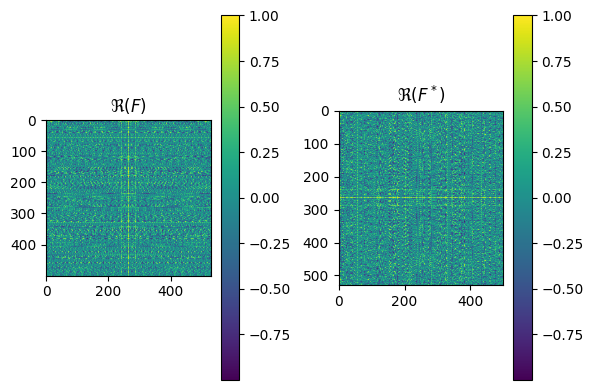

In [54]:

# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT) x @ j.t()  
F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))
# F = torch.exp(1j * 2 * torch.pi * (x@xis.t()).to(dtype=torch.complex128))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag



In [55]:
# get kernel matrix using kernel.kernel_matrix
kernel_matrix = kernel.kernel_matrix(x, x)


In [56]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))

Kernel matrix and kernel approx are close at 0.0001


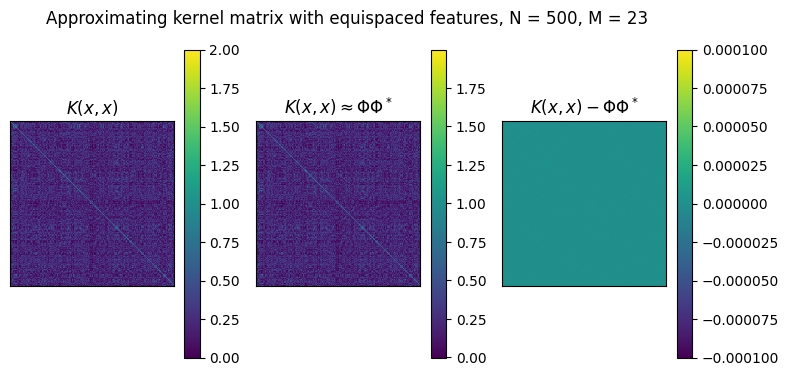

In [57]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')
# Get the maximum absolute value in the difference matrix for colorbar limits
# Set the color limits to be symmetric around zero, bounded by epsilon
im3.set_clim(-EPSILON, EPSILON)

assert torch.allclose(kernel_matrix, kernel_approx.real, atol=EPSILON)
print(f"Kernel matrix and kernel approx are close at {EPSILON}")



In [58]:
import math
import torch
import pytorch_finufft.functional as pff

# ─────────── Inputs (already defined) ────────────────────────────────────
# x      : torch.Tensor of shape (N, d)   — real training locations
# y      : torch.Tensor of shape (N,)     — real training targets
# kernel : object with kernel.spectral_density(xis) method
# EPSILON: float, quadrature tolerance
# ────────────────────────────────────────────────────────────────────────

device = x.device
rdtype = torch.float64
cdtype = torch.complex128
OUT    = (mtot,) * d                     # NUFFT output shape

# 1) Cast to double and move to device
x = x.to(device, rdtype)
y = y.to(device, rdtype)

N, d = x.shape

# 2) Single‐dimensional quadrature (shared across dims)
#    Use the maximal span among the d coordinates
span   = (x.max(dim=0).values - x.min(dim=0).values).max().item()

xcen = torch.zeros(d, device=device, dtype=rdtype)
phi  = 2 * math.pi * h * (x - xcen)     # (N, d)
phi  = phi.T.contiguous()               # (d, N) for finufft

# 5) NUFFT wrappers (torch‑native, CMCL order)
nufft_eps = 1e-15

def finufft1(vals):
    """
    Adjoint NUFFT: nonuniform→uniform.
    vals: (N,) complex
    returns: tensor of shape OUT, then flattened
    """
    arr = pff.finufft_type1(
        phi, vals.to(cdtype), OUT,
        eps=nufft_eps, isign=-1, modeord=False
    )
    return arr.reshape(-1)  # (mtot**d,)

def finufft2(fk_flat):
    """
    Forward NUFFT: uniform→nonuniform.
    fk_flat: (mtot**d,) complex, in CMCL order
    returns: tensor of shape (N,)
    """
    fk_nd = fk_flat.reshape(OUT)
    return pff.finufft_type2(
        phi, fk_nd.to(cdtype),
        eps=nufft_eps, isign=+1, modeord=False
    )

# 6) Sanity checks:

# (a)  F* y  via NUFFT
fadj_y_nufft = finufft1(y)
fadj_y_nufft_ref = F.conj().T@y.to(dtype=torch.complex128)

# (b)  F  ws_nd  via NUFFT
f_ws_nufft  = finufft2(ws)

f_ws_nufft_ref = F@ws

torch.allclose(fadj_y_nufft, fadj_y_nufft_ref)
torch.allclose(f_ws_nufft, f_ws_nufft_ref)
print(f"Multi‑D NUFFT adjoint/forward check passed for OUT={OUT}")


Multi‑D NUFFT adjoint/forward check passed for OUT=(23, 23)


In [59]:
import torch, math
m = mtot//2 -1 
def compute_convolution_vector_vectorized_dD(m: int, x: torch.Tensor, h: float) -> torch.Tensor:
    """
    Multi‑D type‑1 NUFFT convolution vector:
      v[k1,...,kd] = sum_n exp(2πi <k, x_n>)
    """
    device      = x.device
    dtype_real  = x.dtype
    dtype_cmplx = torch.complex64 if dtype_real == torch.float32 else torch.complex128
    if x.ndim == 1:
        x = x[:, None]
    N, d        = x.shape
    eps         = 1e-15

    # (d, N) array of phases
    phi = (2 * math.pi * h * x).T.contiguous().to(dtype_real)

    # all weights = 1 + 0i
    c = torch.ones(N, dtype=dtype_cmplx, device=device)

    # output grid size in each of the d dims
    OUT = tuple([4*m + 1] * d)

    v = pff.finufft_type1(
        phi,    # (d, N)
        c,      # (N,)
        OUT,
        eps=eps,
        isign=-1,
        modeord=False
    )
    return v


In [60]:
m

10

In [61]:
# compute exp(2pi i <xi, x>)
ks = torch.stack(torch.meshgrid(*([torch.arange(-2*m,2*m+1) for _ in range(d)]), indexing='ij'), dim=-1).reshape(-1, d)
vtest = compute_convolution_vector_vectorized_dD(m,x,h)

v_true = torch.exp(-2*math.pi*1j* (x @ (h*ks).T)).sum(dim=0)
assert torch.allclose(vtest.flatten(), v_true, atol=1e-4)

In [62]:
import torch
import torch.nn.functional as nnf
from math import prod

class ToeplitzND:
    """
    Fast d‑dimensional block‑Toeplitz convolution via FFT.
    Caches the FFT of a fixed kernel and then performs
    conv with any flat-or-block input.

    Args:
      v: complex tensor of shape (L1,...,Ld) with Li = 2*ni - 1
      force_pow2: zero‑pad each dim to next power‑of‑2

    Call with x either:
      • flat: 1D tensor of length prod(ni), or
      • block: tensor whose last d dims are exactly (n1,...,nd)
    """
    def __init__(self, v: torch.Tensor, *, force_pow2: bool = True):
        # ensure complex
        if not v.is_complex():
            v = v.to(torch.complex128)
        self.device = v.device

        # dims and block‑sizes
        self.Ls   = list(v.shape)                   # [L1,...,Ld]
        self.ns   = [(L+1)//2 for L in self.Ls]     # [n1,...,nd]
        self.size = prod(self.ns)                   # total block elements

        # fft grid
        if force_pow2:
            self.fft_shape = [1 << (L-1).bit_length() for L in self.Ls]
        else:
            self.fft_shape = self.Ls.copy()

        # pad & cache kernel FFT
        pad = []
        for L, F in zip(reversed(self.Ls), reversed(self.fft_shape)):
            pad += [0, F - L]
        v_pad     = nnf.pad(v.to(self.device), pad)
        self.fft_v = torch.fft.fftn(v_pad, s=self.fft_shape,
                                    dim=list(range(-len(self.Ls), 0)))

        # slice indices for central block
        self.starts = [n-1 for n in self.ns]
        self.ends   = [st+n for st, n in zip(self.starts, self.ns)]

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.device)
        flat = False

        # detect flat vs block
        if x.ndim == 1 and x.numel() == self.size:
            flat = True
            x = x.view(*self.ns)
        elif x.ndim >= len(self.ns) and list(x.shape[-len(self.ns):]) == self.ns:
            flat = False
        else:
            raise AssertionError(
                f"Expected flat length {self.size} or block shape {*self.ns,}, got {tuple(x.shape)}"
            )

        # ensure complex
        if not x.is_complex():
            x = x.to(torch.complex128)

        # pad x → fft grid
        pad = []
        for n, F in zip(reversed(self.ns), reversed(self.fft_shape)):
            pad += [0, F - n]
        x_pad = nnf.pad(x, pad)

        # FFT conv
        y  = torch.fft.ifftn(self.fft_v * torch.fft.fftn(x_pad, s=self.fft_shape,
                                                        dim=list(range(-len(self.ns), 0))),
                             s=self.fft_shape,
                             dim=list(range(-len(self.ns), 0)))

        # slice central block
        slices = [slice(None)]*(y.ndim - len(self.ns))
        for st, en in zip(self.starts, self.ends):
            slices.append(slice(st, en))
        y = y[tuple(slices)]

        return y.flatten() if flat else y


In [63]:
m    = (mtot - 1)//2  
vtest = compute_convolution_vector_vectorized_dD(m, x, h)
toeplitz2d = ToeplitzND(vtest)
beta_flat = torch.randn(mtot**d, dtype=torch.complex128, device=device)
out_flat  = toeplitz2d(beta_flat)    

In [64]:
assert torch.allclose(toeplitz2d(beta_flat), (F.conj().T@F)@ beta_flat)
print(f"ToeplitzND agrees with matrix multiplication")

ToeplitzND agrees with matrix multiplication


# Posterior mean, variance for GP with $x\in \mathbb R^{n\times d}$

In [65]:


# for stochastic variance estimation
def diag_sums_nd(A_apply, J, xis_flat, max_cg_iter, cg_tol):
    N, d_loc = xis_flat.shape
    M_loc = round(N ** (1 / d_loc))
    assert M_loc ** d_loc == N, "xis must lie on tensor grid"
    etas  = (torch.randint(0, 2, (J, N), device=xis_flat.device) * 2 - 1).to(xis_flat.dtype)
    rhs   = ws[None, :] * etas
    us    = BatchConjugateGradients(A_apply, rhs, x0=torch.zeros_like(rhs),
                                    tol=cg_tol, max_iter=max_cg_iter, early_stopping=True).solve()
    gammas = ws[None, :] * us
    shape = (J,) + (M_loc,) * d_loc
    gam_nd, eta_nd = gammas.view(shape), etas.view(shape)
    s_size = (2 * M_loc - 1,) * d_loc
    G = fftn(gam_nd, s=s_size, dim=tuple(range(1, d_loc + 1)))
    E = fftn(eta_nd, s=s_size, dim=tuple(range(1, d_loc + 1)))
    R = ifftn(G * torch.conj(E), s=s_size, dim=tuple(range(1, d_loc + 1)))
    return R.mean(dim=0)

def nufft_var_est_nd(est_sums, h_val, x_center, pts, eps_val):
    B_loc, d_loc = pts.shape
    if est_sums.ndim != d_loc:
        raise ValueError("est_sums wrong dimensionality")
    phi = (2 * math.pi * h_val * (pts - x_center[None, :])).T
    return pff.finufft_type2(phi, est_sums, eps=eps_val, isign=+1, modeord=True).real

## main function

def efgp_nd(x: torch.Tensor, y: torch.Tensor, sigmasq: float,
            kernel: object,  # kernel.spectral_density(xis)
            eps: float,
            x_new: torch.Tensor,
            do_profiling: bool = True,
            opts: Optional[dict] = None) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]:
    """Efficient Gaussian Process Regression for N-D data with optional variance estimation.

    Parameters
    ----------
    estimate_variance : bool  (opts)
        If ``True`` compute predictive variances. Otherwise ``ytrg['var']`` is NaN.
    variance_method   : {'regular', 'stochastic'}  (opts)
        * ``regular``   – exact CG solve per test point.
        * ``stochastic`` – Hutchinson‑FFT diagonal‑sum estimator.
    """

    if opts is None:
        opts = {}
    TWO_PI = 2 * math.pi

    # -------------------- Options ------------------------------------
    cg_tol            = opts.get("cg_tolerance", 1e-4)
    max_cg_iter       = opts.get("max_cg_iter", 5_000)
    estimate_variance = opts.get("estimate_variance", False)
    variance_method   = opts.get("variance_method", "regular").lower()
    hutchinson_probes = opts.get("hutchinson_probes", 8_000)

    x_new_dim_for_var = opts.get("x_new_dim_for_var", 0)
    if x_new_dim_for_var >= x_new.shape[1]:
        raise ValueError(
            f"x_new_dim_for_var ({x_new_dim_for_var}) out of bounds for x_new dim {x_new.shape[1]}")

    # -----------------------------------------------------------------
    activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA] if do_profiling and torch.cuda.is_available() else [ProfilerActivity.CPU]
    with profile(activities=activities, record_shapes=True):

        # ---------- Casts & Devices ----------------------------------
        device  = x.device
        rdtype  = torch.float64
        cdtype  = _cmplx(rdtype)
        sigmasq_scalar = float(sigmasq)
        x       = x.to(device=device, dtype=rdtype)
        y       = y.to(device=device, dtype=rdtype)
        x_new   = x_new.to(device=device, dtype=rdtype)
        N, d    = x.shape
        B       = x_new.shape[0]
        if x_new.shape[1] != d:
            raise ValueError(f"Dim mismatch: x ({d}) vs x_new ({x_new.shape[1]})")

        # ---------- Geometry & Quadrature ----------------------------
        with record_function("geometry_quadrature"):
            x_all = torch.cat((x, x_new), dim=0)
            L     = torch.max(torch.max(x_all, dim=0).values - torch.min(x_all, dim=0).values)
            if L <= 1e-9:
                L = torch.tensor(1.0, device=device, dtype=rdtype)
            xis_1d, h_float, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L.item(), use_integral=False, l2scaled=False)
            h         = torch.tensor(h_float, device=device, dtype=rdtype)
            xis_1d    = xis_1d.to(device=device, dtype=rdtype)
            grids     = torch.meshgrid(*(xis_1d for _ in range(d)), indexing="ij")
            xis       = torch.stack(grids, dim=-1).view(-1, d)            # (M, d)
            M         = xis.shape[0]
            spectral_vals = kernel.spectral_density(xis).to(dtype=cdtype)
            ws        = torch.sqrt(spectral_vals * (h ** d))               # (M,)

        # ---------- NUFFT Setup --------------------------------------
        with record_function("nufft_setup"):
            OUT        = (mtot,) * d
            nufft_eps  = 1e-15
            xcen       = torch.zeros(d, device=device, dtype=rdtype)
            phi_train  = (TWO_PI * h * (x      - xcen)).T.contiguous()
            phi_test   = (TWO_PI * h * (x_new  - xcen)).T.contiguous()

            def finufft1(phi_in, vals):
                phi_in = phi_in.contiguous()
                vals = vals.contiguous()
                fk = pff.finufft_type1(phi_in, vals.to(dtype=cdtype), OUT, eps=nufft_eps, isign=-1, modeord=False)
                return fk.view(-1)

            def finufft2(phi_in, fk_flat):
                phi_in = phi_in.contiguous()
                fk_flat = fk_flat.contiguous()
                fk_nd = fk_flat.view(OUT).to(dtype=cdtype)
                return pff.finufft_type2(phi_in, fk_nd, eps=nufft_eps, isign=+1, modeord=False)

        # ---------- RHS for Mean -------------------------------------
        with record_function("rhs_mean"):
            right_hand_side = ws * finufft1(phi_train, y)

        # ---------- Toeplitz Operator --------------------------------
        with record_function("toeplitz_setup"):
            m_conv       = (mtot - 1) // 2
            v_kernel     = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
            toeplitz     = ToeplitzND(v_kernel, force_pow2=True)
            ns_shape     = tuple(toeplitz.ns)
            ws_block     = ws.view(1, *ns_shape)

            def A_mean(beta):
                beta   = beta.to(dtype=cdtype)
                wbeta  = ws * beta
                Twbeta = toeplitz(wbeta)
                return ws * Twbeta + sigmasq_scalar * beta

            def A_var(gamma):
                is_batch   = gamma.ndim > 1
                gamma      = gamma.to(dtype=cdtype)
                shape_in   = (gamma.shape[0], *ns_shape) if is_batch else (1, *ns_shape)
                g_block    = gamma.view(shape_in)
                Tg         = toeplitz(ws_block * g_block)
                out_block  = ws_block * Tg / sigmasq_scalar + g_block
                return out_block.view(gamma.shape)

        # ---------- Solve for Mean -----------------------------------
        with record_function("cg_solve_mean"):
            beta = ConjugateGradients(A_mean, right_hand_side, x0=torch.zeros_like(right_hand_side, dtype=cdtype),
                                      tol=cg_tol, early_stopping=True).solve()

        # ---------- Predictive Mean ----------------------------------
        with record_function("predict_mean"):
            yhat = finufft2(phi_test, ws * beta).real
        ytrg = {"mean": yhat}

        # ---------- Predictive Variance ------------------------------
        with record_function("predict_variance"):
            if not estimate_variance:
                # user didn't request variance → fill with NaNs
                ytrg["var"] = torch.full((B,), float("nan"), device=device, dtype=rdtype)
            else:
                if variance_method == "regular":
                    # ---- exact CG ----------------------------------
                    f_x   = torch.exp(TWO_PI * 1j * torch.matmul(x_new, xis.T))
                    rhs_v = ws.unsqueeze(0) * f_x.conj()
                    gamma = BatchConjugateGradients(A_var, rhs_v, x0=torch.zeros_like(rhs_v, dtype=cdtype),
                                                    tol=cg_tol, early_stopping=True).solve()
                    s2    = torch.real(torch.einsum('bm,m,bm->b', f_x, ws, gamma)).clamp_min_(0.0)
                    ytrg["var"] = s2

                elif variance_method == "stochastic":
                    # ---- Hutchinson / FFT --------------------------
                    J = hutchinson_probes



                    est_grid = diag_sums_nd(A_var, J, xis, max_cg_iter, cg_tol)
                    s_est    = nufft_var_est_nd(est_grid, h, torch.zeros(d, device=device, dtype=rdtype), x_new, nufft_eps)
                    ytrg["var"] = s_est.clamp_min_(0.0)

                else:
                    raise ValueError("variance_method must be 'regular' or 'stochastic'")

        # ---------- Optional Log Marginal -----------------------------
        if opts.get("get_log_marginal_likelihood", False):
            ytrg["log_marginal_likelihood"] = torch.tensor(float("nan"), device=device, dtype=rdtype)

    # ----------------- Return ----------------------------------------
    return beta, xis, ytrg, ws, toeplitz


In [66]:
cg_tol = 1e-4

# Time stochastic variance estimation
start_time = time.time()
beta, xis, ytrg1, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,
    opts={'cg_tolerance': cg_tol, 'early_stopping': True, 'estimate_variance': True, 'variance_method': 'stochastic', 'hutchinson_probes': 500}
)
stochastic_time = time.time() - start_time
print(f"Stochastic variance estimation time: {stochastic_time:.4f} seconds")

# Time regular variance estimation
start_time = time.time()
beta, xis, ytrg2, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,

    opts={'cg_tolerance': cg_tol, 'estimate_variance': True,
    'variance_method':'regular','early_stopping': True}
)
regular_time = time.time() - start_time
print(f"Regular variance estimation time: {regular_time:.4f} seconds")

# Time default settings
start_time = time.time()
beta, xis, ytrg, ws, toeplitz = efgp_nd(x, y, sigmasq, kernel, EPSILON, x_new)
default_time = time.time() - start_time
print(f"Default settings time: {default_time:.4f} seconds")

/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/finufft/_interfaces.py:329: UserWarning:

Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)

/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/finufft/_interfaces.py:329: UserWarning:

Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)



Stochastic variance estimation time: 2.8755 seconds
Regular variance estimation time: 0.6351 seconds
Default settings time: 0.0826 seconds


In [23]:
if d == 1:
    # plot x_new against ytrg['var'] and ytrg2['var']
    plt.plot(x_new.cpu(), ytrg1['var'].cpu(), 'o')
    plt.plot(x_new.cpu(), ytrg2['var'].cpu(), 'o')
    plt.xlabel('x_new')
    plt.ylabel('ytrg["var"]')
    plt.legend(['stochastic', 'regular'])
    plt.show()




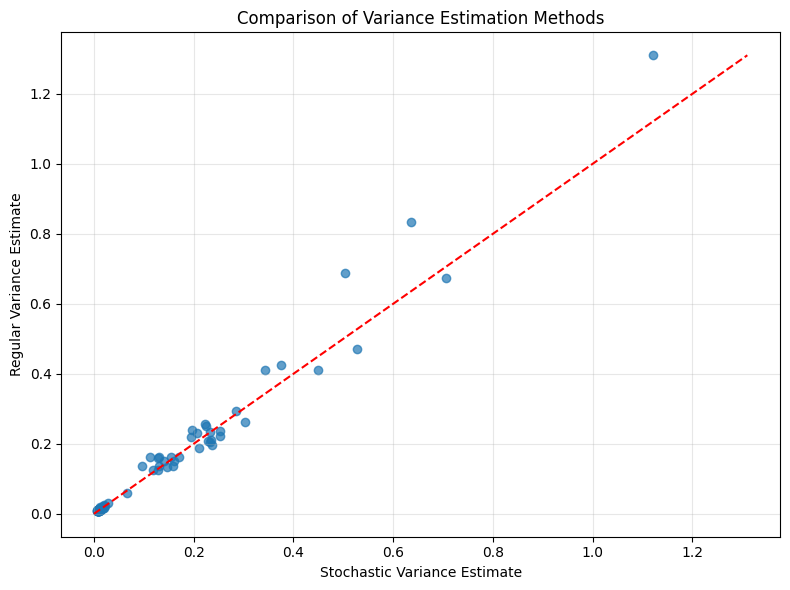

Correlation between stochastic and regular variance estimates: 0.9865


In [24]:
# Create a scatter plot comparing stochastic vs regular variance estimates
plt.figure(figsize=(8, 6))
plt.scatter(ytrg1['var'].cpu(), ytrg2['var'].cpu(), alpha=0.7)
plt.plot([0, ytrg2['var'].cpu().max()], [0, ytrg2['var'].cpu().max()], 'r--')  # Add identity line
plt.xlabel('Stochastic Variance Estimate')
plt.ylabel('Regular Variance Estimate')
plt.title('Comparison of Variance Estimation Methods')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between the two variance estimates
correlation = torch.corrcoef(torch.stack([ytrg1['var'], ytrg2['var']]))[0, 1]
print(f"Correlation between stochastic and regular variance estimates: {correlation:.4f}")


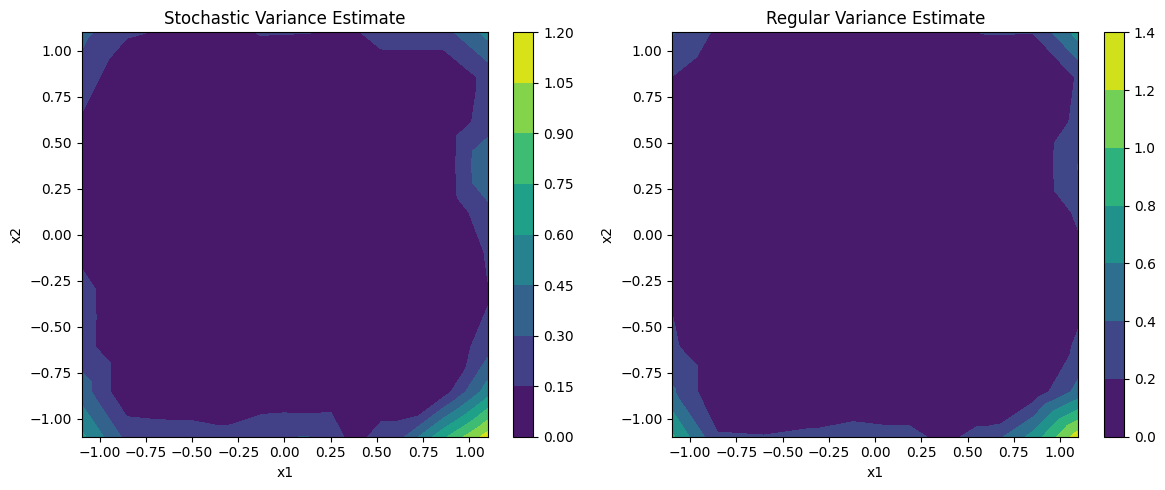

In [25]:
# Check dimensionality and plot accordingly
if x_new.shape[1] > 1:  # For d > 1
    # Create contour plots for variance comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Extract coordinates
    x1 = x_new[:, 0].cpu()
    x2 = x_new[:, 1].cpu()
    var1 = ytrg1['var'].cpu()
    var2 = ytrg2['var'].cpu()
    
    # Create contour plots
    sc1 = ax1.tricontourf(x1, x2, var1, cmap='viridis')
    ax1.set_title('Stochastic Variance Estimate')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    fig.colorbar(sc1, ax=ax1)
    
    sc2 = ax2.tricontourf(x1, x2, var2, cmap='viridis')
    ax2.set_title('Regular Variance Estimate')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    fig.colorbar(sc2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
else:  # For d = 1
    # plot x_new against ytrg['var'] and ytrg2['var']
    plt.plot(x_new.cpu(), ytrg1['var'].cpu(), 'o')
    plt.plot(x_new.cpu(), ytrg2['var'].cpu(), 'o')
    plt.xlabel('x_new')
    plt.ylabel('ytrg["var"]')
    # add a legend
    plt.legend(['stochastic', 'regular'])
    plt.show()


In [26]:
beta, xis, ytrg, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,

    opts={'cg_tolerance': cg_tol, 'estimate_variance': True,
    'variance_method':'regular','early_stopping': True}
)
if d == 2:

    import plotly.graph_objects as go
    import numpy as np
    from scipy.interpolate import griddata

    # --- Prepare Data for Plotting ---
    # Extract x1, x2 coordinates and mean values from tensors
    x1 = x_new[:, 0].cpu().numpy()
    x2 = x_new[:, 1].cpu().numpy()
    mean_values = ytrg['mean'].cpu().numpy()

    # Create a grid for the surface plot
    x1_grid = np.linspace(x1.min(), x1.max(), 100)
    x2_grid = np.linspace(x2.min(), x2.max(), 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    # Interpolate mean values onto the grid for smooth surface visualization
    mean_surface = griddata(
        points=(x1, x2), 
        values=mean_values, 
        xi=(X1, X2), 
        method='cubic'
    )

    # --- Create Interactive 3D Plot ---
    fig = go.Figure()

    # Add the mean surface with transparency
    fig.add_trace(go.Surface(
        z=mean_surface,
        x=X1,
        y=X2,
        colorscale='Viridis',
        opacity=0.8,  # Adjust transparency for better visualization
        name='EFGP Mean',
        colorbar=dict(
            title=dict(
                text="Mean Value",
                font=dict(size=14)
            ),
            tickfont=dict(size=12)
        )
    ))

    # Add scatter points for the true data
    fig.add_trace(go.Scatter3d(
        x=x[:, 0].cpu().numpy(),
        y=x[:, 1].cpu().numpy(),
        z=y.cpu().numpy(),
        mode='markers',
        marker=dict(
            size=4,  # Smaller scatter points
            color='red',
            opacity=0.9,  # Slight transparency for markers
            symbol='circle'
        ),
        name='True Data'
    ))

    # --- Update Layout for Better Visualization ---
    fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=1.5, y=1.5, z=1), # Make x and y dimensions wider relative to z
            xaxis=dict(
                title=dict(
                    text='x₁',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title=dict(
                    text='x₂',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title=dict(
                    text='Mean/True Data',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1)  # Adjust camera angle for better view
            )
        ),
        title=dict(
            text='EFGP Mean and True Data',
            font=dict(size=18),
            x=0.5,  # Center the title
            xanchor='center'
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',  # Add a semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=0, r=0, t=50, b=0),  # Reduce margins for a cleaner look
        width=800,  # Increase figure width
        height=600   # Increase figure height
    )

    # Display the plot
    fig.show()




1. Get rademachers
2. hit ws* each rademacher 
3. Solve gamma = (DF^*FD/sigma^2 + I)^{-1}D eta 
4. <ws*original rademacher,  gamma > 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Only make a 1D plot when the input dimension is 1
if d == 1:
    # Move tensors to CPU / numpy
    x_np       = x.detach().cpu().numpy().flatten()
    y_np       = y.detach().cpu().numpy().flatten()
    x_new_np   = x_new.detach().cpu().numpy().flatten()
    mean_np    = ytrg['mean'].detach().cpu().numpy().flatten()
    var_np     = ytrg['var'].detach().cpu().numpy().flatten()
    std_np     = np.sqrt(var_np)

    # Sort by x_new so that lines are not jumbled
    sort_idx     = np.argsort(x_new_np)
    x_new_sorted = x_new_np[sort_idx]
    mean_sorted  = mean_np[sort_idx]
    std_sorted   = std_np[sort_idx]

    # Plot data, mean and ±2σ band
    plt.figure(figsize=(10, 6))
    plt.plot(x_np, y_np, 'kx', label='Training Data')
    plt.plot(x_new_sorted, mean_sorted, 'b-', label='Mean Prediction')
    plt.fill_between(
        x_new_sorted,
        mean_sorted - 2 * std_sorted,
        mean_sorted + 2 * std_sorted,
        color='blue',
        alpha=0.2,
        label='95% Confidence Interval on Mean Function'
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Mean Prediction with 95% CI')
    plt.legend()
    plt.show()


# Doing some direct calculations to check 

In [28]:
N, d = x.shape
B = x_new.shape[0]
M = xis.shape[0]

x = x.to(device, rdtype)
y = y.to(device, rdtype)
x_new = x_new.to(device, rdtype)
xis = xis.to(device, rdtype)
ws = ws.to(device, cdtype)
sigmasq = torch.tensor(sigmasq, device=device, dtype=rdtype)

F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
F_new = torch.exp(2 * math.pi * 1j * torch.matmul(x_new, xis.T)).to(cdtype)

W_F_train_star = ws.unsqueeze(1) * F_train.conj().T

K_train = (F_train * ws) @ W_F_train_star
K_new_train = (F_new * ws) @ W_F_train_star
diag_K_new_new = torch.sum(torch.abs(F_new * ws)**2, dim=1)

I_N = torch.eye(N, device=device, dtype=rdtype)
K_plus_noise = K_train + sigmasq * I_N
if K_plus_noise.dtype != cdtype:
    K_plus_noise = K_plus_noise.to(cdtype)

y_c = y.to(cdtype)
try:
    z = torch.linalg.solve(K_plus_noise, y_c)
except torch.linalg.LinAlgError:
    z = torch.full_like(y_c, float('nan'))

yhat_direct = (K_new_train @ z).real

K_new_train_conj_T = K_new_train.conj().T
try:
    Z = torch.linalg.solve(K_plus_noise, K_new_train_conj_T)
except torch.linalg.LinAlgError:
    Z = torch.full((N, B), float('nan'), device=device, dtype=cdtype)

var_reduction_diag = torch.sum(K_new_train * Z.T, dim=1)
variance_direct = diag_K_new_new - var_reduction_diag.real
variance_direct = torch.clamp(variance_direct, min=0.0)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_70862/1467099095.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [29]:
assert torch.allclose(ytrg['mean'], yhat_direct, atol=1e-4)
print("ytrg['mean'] and yhat_direct are the same")
# if variance exists
if 'var' in ytrg:
    # Check variance
    assert torch.allclose(ytrg['var'], variance_direct, atol=1e-4)
    print("ytrg['var'] and variance_direct are the same")


ytrg['mean'] and yhat_direct are the same
ytrg['var'] and variance_direct are the same


# Version with FFT for computing all the c_k's at once

In [30]:
ns_shape = tuple(toeplitz.ns)

ws_block_view = ws.view(1, *ns_shape)

# Operator for variance: A_var = D T D / sigmasq + I
# This operator is equivalent to 'A' in the working snippet
def A_var_apply(gamma_in: torch.Tensor) -> torch.Tensor:
    is_batch = gamma_in.ndim > 1
    if not gamma_in.is_complex(): gamma_in = gamma_in.to(dtype=cdtype)
    B_dim = gamma_in.shape[0] if is_batch else 1
    in_shape = (B_dim, *ns_shape) if is_batch else (1, *ns_shape)
    out_shape = (B_dim, M) if is_batch else (M,)

    gamma_in_block = gamma_in.view(in_shape)
    w_gamma_block = ws_block_view * gamma_in_block # Apply D
    T_W_gamma_block = toeplitz(w_gamma_block)      # Apply T = F^H F
    result_block = ws_block_view * T_W_gamma_block # Apply D
    result_block = result_block / sigmasq   # Divide by sigma^2
    result_flat = result_block.view(out_shape)     # Reshape back
    result_flat = torch.add(result_flat, gamma_in, alpha=1.0) # Add Identity term
    return result_flat

In [31]:
# Recompute F_train (needed for A)
print("Computing F_train...")
F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
# Define D (Diagonal matrix from weights)
print("Defining D...")
D = torch.diag(ws) # Assuming ws components are positive sqrt
# Create identity matrix for M dimensions
I_M = torch.eye(M, device=device, dtype=cdtype) # Use cdtype for complex arithmetic

# 1) Re-build A = (D F^H F D)/σ^2 + I_M
print("Building matrix A...")
F_conj_T = F_train.conj().T
A = (D @ F_conj_T @ F_train @ D) / sigmasq + I_M

# Define the batched matrix-vector product for A
def A_apply_batched(x):
    # x is (J, M). A is (M, M).
    return x @ A.conj() # (J, M) @ (M, M) -> (J, M)



Computing F_train...
Defining D...
Building matrix A...


In [32]:
r = torch.randn(1,M,device=device,dtype=cdtype)
assert torch.allclose(A_var_apply(r),A_apply_batched(r))
print(f"Agreement between applying that C matrix manually versus toeplitz")

Agreement between applying that C matrix manually versus toeplitz


$2(2m+1)^d - 1$ diagonal sums



In [33]:
J = 500

offsets = list(range(-(M-1), M))
# Use a very tight tolerance
cg_tol = 1e-4 
max_cg_iter = M * 5 # Increase iterations further if needed


In [34]:
import torch, math
from torch.fft import fftn, ifftn

def diag_sums_nd(
    A_apply_batched,
    J,             # number of probes
    xis,           # (N, d) grid of frequencies
    max_cg_iter,
    cg_tol
):
    """
    Returns est_sums_nd of shape (2*M-1,)*d
    where N = (2m+1)**d, M=2m+1, and
    est_sums_nd[r1,…,rd] ≈
       sum_{i: k^(i+ r) in grid} Cinv[i, i+r]
    """
    N, d = xis.shape
    # recover M from N = M**d
    M = round(N ** (1/d))
    assert M**d == N, "xis must lie on a full tensor grid"
    # 1) build Hutchinson probes on the flattened grid
    etas = (torch.randint(0,2,(J, N), device=xis.device)*2 - 1).to(xis.dtype)
    # 2) solve A u = D eta  →  gammas = D u ≈ C^{-1} eta
    rhs = ws[None,:] * etas            # shape (J, N)
    cg  = BatchConjugateGradients(A_apply_batched, rhs,
                                   tol=cg_tol, max_iter=max_cg_iter,
                                   x0=torch.zeros_like(rhs),
                                   early_stopping=True)
    us      = cg.solve()               # (J, N)
    gammas  = ws[None,:] * us          # (J, N)
    # 3) reshape into J × (M×M×…×M)
    shape = (J,) + (M,)*d # (J, mtot, mtot, ..., mtot)
    gammas_nd = gammas.view(shape)
    etas_nd   = etas.view(shape)
    # 4) do N-D convolution via FFTn/​IFFTn:
    #    we want linear corr of length 2*M-1 along each axis → s = [2*M-1]*d
    s = (2*M-1,)*d
    G = fftn(gammas_nd, s=s, dim=tuple(range(1,d+1)))
    E = fftn(etas_nd,   s=s, dim=tuple(range(1,d+1)))
    R = ifftn(G * torch.conj(E), s=s, dim=tuple(range(1,d+1)))
    # 5) average over the J probes
    c_grid = R.mean(dim=0)    # shape = (2*M-1,)*d
    return c_grid
est_sums = diag_sums_nd(A_var_apply,J,xis,max_cg_iter,cg_tol)



In [35]:
45**2

2025

In [36]:
xis

tensor([[-2.8992, -2.8992],
        [-2.8992, -2.6357],
        [-2.8992, -2.3721],
        ...,
        [ 2.8992,  2.3721],
        [ 2.8992,  2.6357],
        [ 2.8992,  2.8992]], dtype=torch.float64)

max abs err: 0.046007486681838836
rmse:       0.0053086944683945975


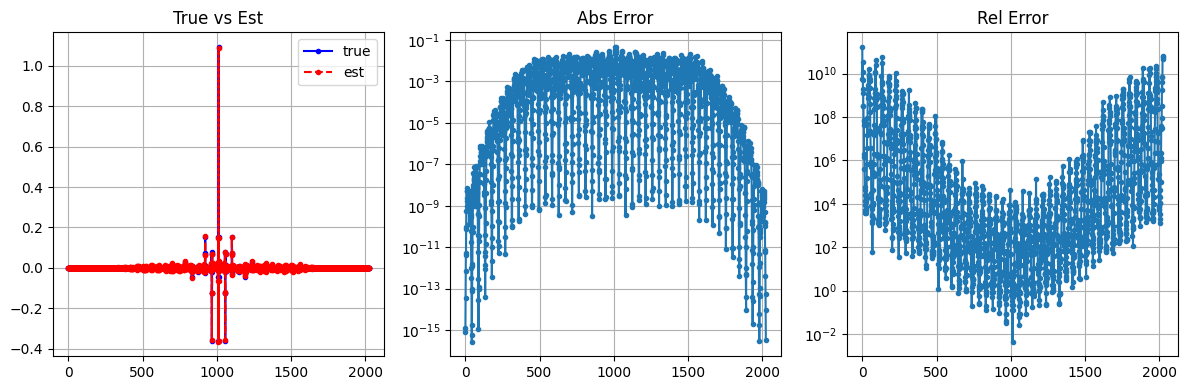

In [37]:
# -----------------------------------------------------------------------------
# 1) get the J-probe cross-correlation R via diag_sums_nd (no change)
# -----------------------------------------------------------------------------
# est_sums_grid has shape (2*M-1,)*d but with zero-offset at index 0
est_sums_grid_og = diag_sums_nd(
    A_var_apply,
    J,
    xis,
    max_cg_iter,
    cg_tol
)

# 2) shift so that (0,…,0) lives at the center (M-1,…,M-1)
N, d = xis.shape
M     = round(N ** (1/d))   # = 2*m+1
shifts = (M-1,)*d
dims   = tuple(range(d))
est_sums_grid = est_sums_grid_og.roll(shifts=shifts, dims=dims)

# 3) flatten to compare with true_sums
est_sums = est_sums_grid.flatten()


# -----------------------------------------------------------------------------
# 4) rebuild true_grid exactly as before, flatten
# -----------------------------------------------------------------------------
D_inv = torch.diag(1.0 / torch.diag(D))
A = (D @ F_conj_T @ F_train @ D) / sigmasq + I_M


C0 = D_inv @ A @ D_inv
Cinv = torch.linalg.inv(C0)
true_grid = torch.zeros((4*m+1,)*d,
                        device=Cinv.device,
                        dtype=Cinv.dtype)
k_grid    = (xis/h).round().long()

for j in range(N):
    kj = k_grid[j]
    for ℓ in range(N):
        r   = (k_grid[ℓ] - kj).tolist()
        idx = tuple(ri + 2*m for ri in r)
        true_grid[idx] += Cinv[j, ℓ]

true_sums = true_grid.flatten()


# -----------------------------------------------------------------------------
# 5) error, printing, plotting
# -----------------------------------------------------------------------------
err   = est_sums - true_sums
rel   = err / true_sums
x_ax  = torch.arange(true_sums.numel()).cpu().numpy()

print("max abs err:", err.abs().max().item())
print("rmse:      ", torch.sqrt((err.abs()**2).mean()).item())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(x_ax, true_sums.real.cpu(), 'b.-', label="true")
plt.plot(x_ax, est_sums.real.cpu(), 'r.--', label="est")
plt.legend(); plt.grid(True); plt.title("True vs Est")

plt.subplot(1,3,2)
plt.plot(x_ax, err.abs().cpu(), '.-')
plt.yscale('log'); plt.title("Abs Error"); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(x_ax, rel.abs().cpu(), '.-')
plt.yscale('log'); plt.title("Rel Error"); plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
M

23

In [39]:
C0.shape

torch.Size([529, 529])

/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/finufft/_interfaces.py:329: UserWarning:

Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)

/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/finufft/_interfaces.py:329: UserWarning:

Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)



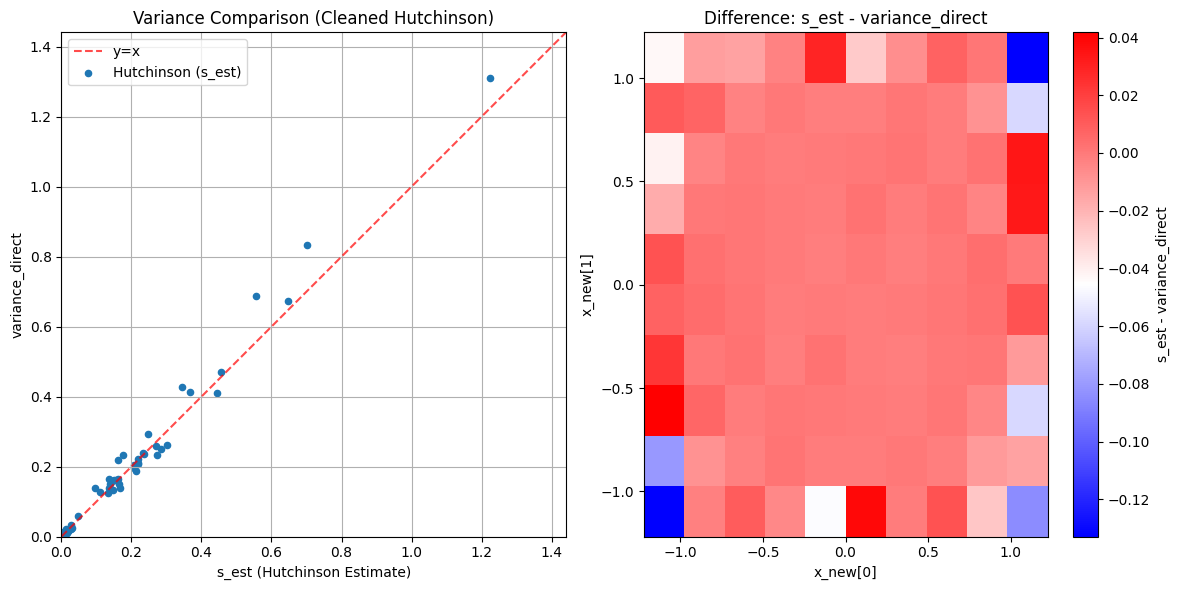

Hutchinson Estimation Block Finished.


In [40]:
def nufft_var_est_nd(
    est_sums: torch.Tensor,    # shape = (2*M-1,)*d, FFT-order
    h:        float,
    xcen:     torch.Tensor,    # shape = (d,)
    x_new:    torch.Tensor,    # shape = (B, d)
    nufft_eps: float,
) -> torch.Tensor:
    """
    Evaluate V(x_new) = sum_{r in [-M+1..M-1]^d} 
       est_sums[r_idx] * exp(2πi * h * r ⋅ (x_new - xcen))
    
    est_sums is exactly the c_grid that diag_sums_nd returned.
    """

    B, d = x_new.shape
    assert est_sums.ndim == d, "est_sums must be a d-D grid of shape (2*M-1,)*d"
    # build phi as a (d, B) array:
    #    phi[r,b] = 2π * h * (x_new[b,r] - xcen[r])
    phi_nd = (2 * math.pi * h * (x_new - xcen[None, :])).T  # shape (d, B)

    # generic Type-2 NUFFT in d dims, with modeord=True
    s_complex = pff.finufft_type2(
        phi_nd,
        est_sums,      # shape = (2*M-1,)*d, FFT‐order
        eps     = nufft_eps,
        isign   = +1,
        modeord = True
    )

    return s_complex.real   # shape (B,)


s_est = nufft_var_est_nd(est_sums_grid_og,h,xcen,x_new,nufft_eps)
# s_est = nufft_var_est(est_sums,h,xcen,nufft_eps)

all_vals = torch.cat((s_est.cpu(), variance_direct.cpu())).numpy()
min_val = min(0, all_vals.min()) * 1.1
max_val = max(0, all_vals.max()) * 1.1
lims = [min_val, max_val]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lims, lims, 'r--', alpha=0.7, label='y=x')
plt.scatter(s_est.cpu().numpy(), variance_direct.cpu().numpy(), label="Hutchinson (s_est)", s=20)
plt.xlabel("s_est (Hutchinson Estimate)")
plt.ylabel("variance_direct")
plt.title("Variance Comparison (Cleaned Hutchinson)")
plt.legend()
plt.grid(True)
plt.xlim(lims)
plt.ylim(lims)

if d == 1:
    x_new_1d = x_new.flatten()
    plt.subplot(1, 2, 2)
    plt.plot(x_new_1d.cpu().numpy(), s_est.cpu().numpy(), 'b.-', label='s_est (Hutchinson)')
    plt.plot(x_new_1d.cpu().numpy(), variance_direct.cpu().numpy(), 'r.-', label='variance_direct')
    plt.xlabel("x_new")
    plt.ylabel("Variance")
    plt.title("Variance Estimates vs. Position")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
elif d == 2:
    # Compute the difference between s_est and variance_direct
    diff = (s_est - variance_direct).cpu().numpy()
    # Assume x_new is (B, 2) and forms a grid
    x = x_new[:, 0].cpu().numpy()
    y = x_new[:, 1].cpu().numpy()
    # Try to infer grid shape
    B = x_new.shape[0]
    n = int(np.sqrt(B))
    if n * n == B:
        X = x.reshape(n, n)
        Y = y.reshape(n, n)
        Z = diff.reshape(n, n)
        plt.subplot(1, 2, 2)
        im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='bwr')
        plt.colorbar(im, label="s_est - variance_direct")
        plt.xlabel("x_new[0]")
        plt.ylabel("x_new[1]")
        plt.title("Difference: s_est - variance_direct")
        plt.tight_layout()
        plt.show()
    else:
        # fallback: scatter plot if not a grid
        plt.subplot(1, 2, 2)
        sc = plt.scatter(x, y, c=diff, cmap='bwr')
        plt.colorbar(sc, label="s_est - variance_direct")
        plt.xlabel("x_new[0]")
        plt.ylabel("x_new[1]")
        plt.title("Difference: s_est - variance_direct")
        plt.tight_layout()
        plt.show()

print("Hutchinson Estimation Block Finished.")


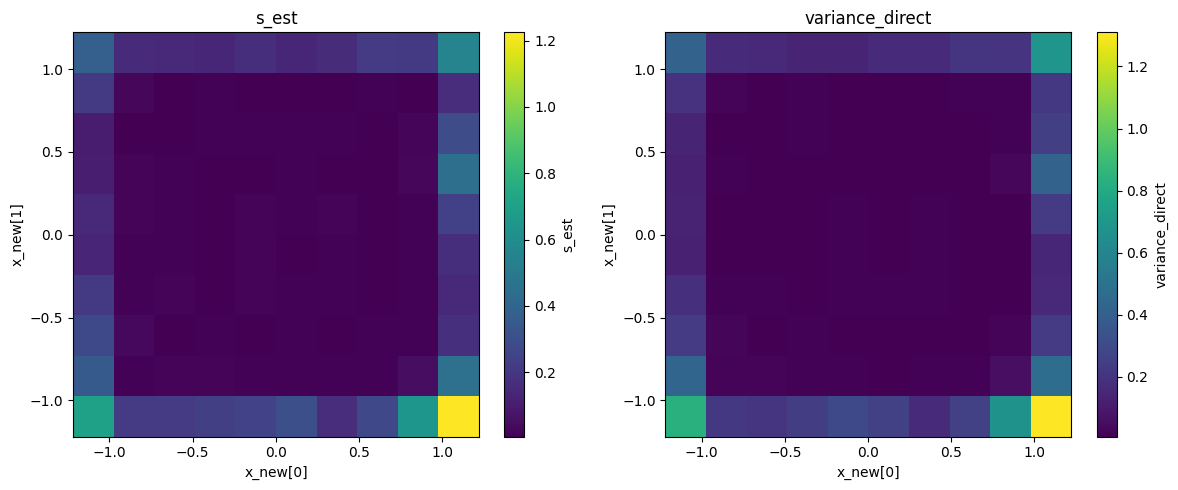

In [41]:
if d == 2:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Assume x_new is (B, 2) and forms a grid
    x = x_new[:, 0].cpu().numpy()
    y = x_new[:, 1].cpu().numpy()
    B = x_new.shape[0]
    n = int(np.sqrt(B))
    if n * n == B:
        X = x.reshape(n, n)
        Y = y.reshape(n, n)
        Z1 = s_est.cpu().numpy().reshape(n, n)
        Z2 = variance_direct.cpu().numpy().reshape(n, n)
        im1 = axs[0].pcolormesh(X, Y, Z1, shading='auto', cmap='viridis')
        fig.colorbar(im1, ax=axs[0], label="s_est")
        axs[0].set_title("s_est")
        axs[0].set_xlabel("x_new[0]")
        axs[0].set_ylabel("x_new[1]")
        im2 = axs[1].pcolormesh(X, Y, Z2, shading='auto', cmap='viridis')
        fig.colorbar(im2, ax=axs[1], label="variance_direct")
        axs[1].set_title("variance_direct")
        axs[1].set_xlabel("x_new[0]")
        axs[1].set_ylabel("x_new[1]")
    else:
        sc1 = axs[0].scatter(x, y, c=s_est.cpu().numpy(), cmap='viridis')
        fig.colorbar(sc1, ax=axs[0], label="s_est")
        axs[0].set_title("s_est")
        axs[0].set_xlabel("x_new[0]")
        axs[0].set_ylabel("x_new[1]")
        sc2 = axs[1].scatter(x, y, c=variance_direct.cpu().numpy(), cmap='viridis')
        fig.colorbar(sc2, ax=axs[1], label="variance_direct")
        axs[1].set_title("variance_direct")
        axs[1].set_xlabel("x_new[0]")
        axs[1].set_ylabel("x_new[1]")
    plt.tight_layout()
    plt.show()


# d= 1

In [42]:
# Enforce symmetry of est_sums around its center by averaging each pair of mirrored entries
# (so that est_sums[j] == est_sums[-j] for all j)
est_sums = (est_sums + est_sums.flip(0)) * 0.5
